In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from datetime import timedelta
import random
from tqdm import tqdm

# Get the current date as a string in the format "YYYY-MM-DD"

# Download historical stock price and additional feature data

imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()

sp500_stocks = pd.read_csv('spx500.csv')
sp500_stocks = sp500_stocks['Symbol'].tolist()
start_date = '2009-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

Helper Functions:

In [66]:
def get_stock_price(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def get_stock_price_daily(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    return temp_df

def save_weekly_prices(stock_list):
    full_df= pd.DataFrame()
    for t in stock_list:
        t_df = get_stock_price(t)
        if t_df is not None:
            full_df[t] = t_df
    full_df.to_csv('imploded_stock_prices.csv')

def get_random_stock_ticker(stock_list):
   
    random_ticker = random.choice(stock_list)

    return random_ticker




## Implosion Detection

The method we use for crash detection is to check for (firm-specific) returns that are in the 0.1% of deepest crashes.

In [76]:
def get_firm_specific_returns(weekly_data):
    returns = weekly_data.pct_change()
    return returns
    market_df = get_stock_price('^GSPC') #what market index should i use?
    market_returns = market_df.pct_change()
    market_returns = market_returns.to_frame()
    market_returns.rename(columns={'Adj Close': 'rt-2'}, inplace=True)
    market_returns['rt-1'] = market_returns['rt-2'].shift(1)
    market_returns['rt'] = market_returns['rt-2'].shift(2)
    market_returns['rt+1'] = market_returns['rt-2'].shift(3)
    market_returns['rt+2'] = market_returns['rt-2'].shift(4)
    market_returns['firm_returns'] = returns
    market_returns.dropna(inplace=True)
    market_returns['firm_specific_returns'] = 0
    y_values = []
    X_values = []

    for date, row in market_returns.iterrows():
        y = market_returns.loc[date, 'firm_returns'].reshape(-1, 1) #num of rows unknown  but cols must be 1
        X = market_returns.loc[date, ['rt-2', 'rt-1', 'rt', 'rt+1', 'rt+2']].values.reshape(1, -1)
        y_values.append(y)
        X_values.append(X)

    lr = LinearRegression()
    lr.fit(np.vstack(X_values), np.vstack(y_values))
    y_fits = lr.predict(np.vstack(X_values))
    epsilon = np.vstack(y_values) - y_fits

    for i, date in enumerate(market_returns.index):
        market_returns.loc[date, 'firm_specific_returns'] = np.log(1 + epsilon[i])

    return market_returns['firm_specific_returns']

def get_stock_dds(ds, price_drop_thresh):
    ds = ds.to_frame()
    pmin_pmax = (ds['Adj Close'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = (np.array(ds['Adj Close'][pmin.index]) - np.array(ds['Adj Close'][pmax.index])) \
        / np.array(ds['Adj Close'][pmax.index])

    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
            'duration': dur}  
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))

    major_dds = df_d[df_d['drawdown'] < price_drop_thresh]['d_end'].tolist()
    return major_dds



    pmin_pmax = (ds['Adj Close'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = (np.array(ds['Adj Close'][pmin.index]) - np.array(ds['Adj Close'][pmax.index])) \
        / np.array(ds['Adj Close'][pmax.index])

    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
            'duration': dur}  
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))

    major_dds = df_d[df_d['drawdown'] < price_drop_thresh]['d_end'].tolist()
    return major_dds

def get_death_crosses(ticker):
    temp_df = get_stock_price_daily(ticker)
    temp_df['50-day'] = temp_df['Adj Close'].rolling(50).mean()
    temp_df['200-day'] = temp_df['Adj Close'].rolling(200).mean()
    i = 200
    imp_dates = []
    for i in range(200, len(temp_df)):
        if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:
            imp_dates.append(temp_df.index[i])
    return imp_dates

def get_implosion_dates3(ticker, price_thresh, period_thresh):
    temp_df = get_stock_price_daily(ticker)
    temp_df['50-day'] = temp_df['Adj Close'].rolling(50).mean()
    temp_df['200-day'] = temp_df['Adj Close'].rolling(200).mean()
    i = 200
    # while i < len(temp_df):
    #     start_i = i
    #     while i < len(temp_df) and temp_df.iloc[i]['50-day'] < temp_df.iloc[i]['200-day']:
    #         i+=1
    #     if i>=10 and i <len(temp_df):
    #         if (temp_df['Adj Close'][i] - temp_df['Adj Close'][start_i])/temp_df['Adj Close'][start_i] < -0.6:
    #             imp_dates.append((temp_df.index[start_i], temp_df.index[i]))
    #     i+=1
    imp_dates = []
    for i in range(200, len(temp_df)):
        if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:
            imp_period = check_implosion(i-1, temp_df['Adj Close'], price_thresh)
            if imp_period > period_thresh and i+imp_period < len(temp_df):
                imp_dates.append((temp_df.index[i], temp_df.index[i+imp_period]))
    return imp_dates


def get_implosion_dates2(firm_price, price_drop_thresh, period_thresh):
    dd_dates = get_stock_dds(firm_price, price_drop_thresh)
    imp_dates = []
    for d in dd_dates:
        idx = firm_price.index.get_loc(d)
        imp_period = check_implosion(idx, firm_price, price_drop_thresh)
        if imp_period > period_thresh:
            imp_dates.append((d, firm_price.index[idx+imp_period]))
    return imp_dates
    

# def does_stock_implode(firm_price, price_drop_thresh, period_thresh):
#     crash_dates = []
#     imp_dates = []
#     i = 52
#     while i < len(firm_price):
#         current_date = firm_price.index[i]
#         current_price = firm_price.iloc[i]
#         prev_year_data = firm_price.iloc[i-52:i]
#         if len(prev_year_data) != 0:
#             mean_price = prev_year_data.mean()
#             std_ret= prev_year_data.std()
#             #threshold = mean_ret + norm.ppf(0.005)*std_ret
#             #(current_ret - mean_ret)/mean_ret < -0.8
#             if (current_price - mean_price)/mean_price < price_drop_thresh:
#                 imp_period = check_implosion(i, firm_price, current_price, price_drop_thresh)
#                 if imp_period > period_thresh:
#                     return True
#                 else:
#                     i+=imp_period
#                 #crash_dates.append(current_date)
#         i+=1
#     return False

def get_implosion_dates(firm_price, price_drop_thresh, period_thresh):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            std_ret= prev_year_data.std()
            #threshold = mean_ret + norm.ppf(0.005)*std_ret
            #(current_ret - mean_ret)/mean_ret < -0.8
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price,  price_drop_thresh)
                if imp_period > period_thresh:
                    imp_dates.append((current_date, firm_price.index[i+imp_period]))
                i+=imp_period
                #crash_dates.append(current_date)
        i+=1
    return imp_dates

def get_imp_len(firm_price, price_drop_thresh):
    crash_dates = []
    imp_dates = []
    i = 52
    n_imp = 0
    imp_sum = 0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            std_ret= prev_year_data.std()
            #threshold = mean_ret + norm.ppf(0.005)*std_ret
            #(current_ret - mean_ret)/mean_ret < -0.8
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price, current_price, price_drop_thresh)
                return imp_period
                #crash_dates.append(current_date)
        i+=1
    return None

def plot_crashes(stock_series, crash_dates, ticker):
    if stock_series is not None:
        plt.figure(figsize=(15, 5))
        plt.plot(stock_series.index, stock_series, label=ticker)
        for x1 in crash_dates:
            plt.axvspan(x1, x1, alpha=0.5, color='blue')
        plt.legend()
        plt.show()

def plot_implosions(stock_series, imp_dates, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        plt.axvspan(i[0], i[1], alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def plot_price(stock_series,ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    plt.legend()
    plt.show()


def plot_cum_ret(stock_series,ticker):
    returns = stock_series.diff()
    returns = returns.cumsum()
    plt.figure(figsize=(15, 5))
    plt.plot(returns.index, returns, label=ticker)
    plt.legend()
    plt.show()


def check_implosion(idx, firm_price, imp_thresh):
    i = idx
    start_price=firm_price.iloc[idx]
    i+=1
    period=0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        if (current_price-start_price)/start_price > -imp_thresh/2:
            return period
        period+=1
        i+=1
    return period

def do_implosion(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        imp_dates = get_implosion_dates(stock_series, -0.6, 52)
        plot_implosions(stock_series, imp_dates, ticker)
        






#returns doesnt seem to work

### Average Implosion Lengths

In [74]:
def get_avg_imp_len():
    imp_sum = 0
    imploded_list = imploded_stocks[:50]
    n_imps = 0
    price_drop_threshs = [-0.4, -0.5, -0.6, -0.7, -0.8]
    for p in price_drop_threshs:
        for t in imploded_list:
            stock_series = get_stock_price(t)
            if stock_series is not None:
                imp_period = get_imp_len(stock_series, p)
                if imp_period is not None:
                    imp_sum += imp_period
                    n_imps +=1
        if n_imps != 0:
            print(f"For price drop of {p} average implosion length is {imp_sum/n_imps}")

#get_avg_imp_len()

on avg looking at 130-140 week implosion periods

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


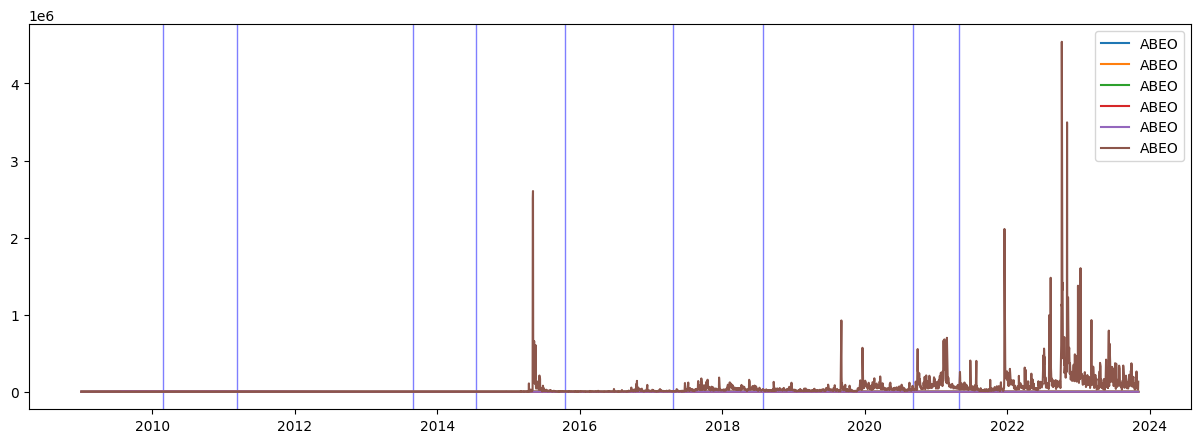

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


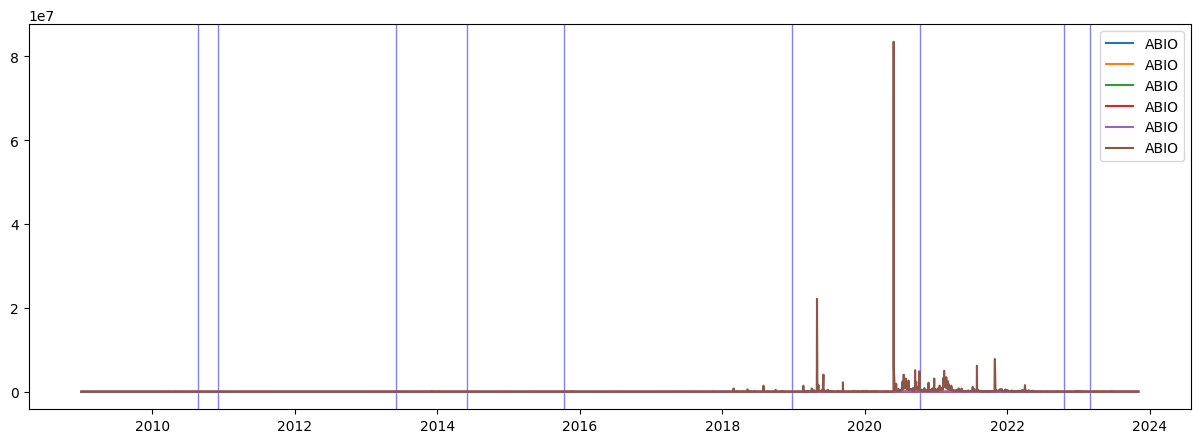

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


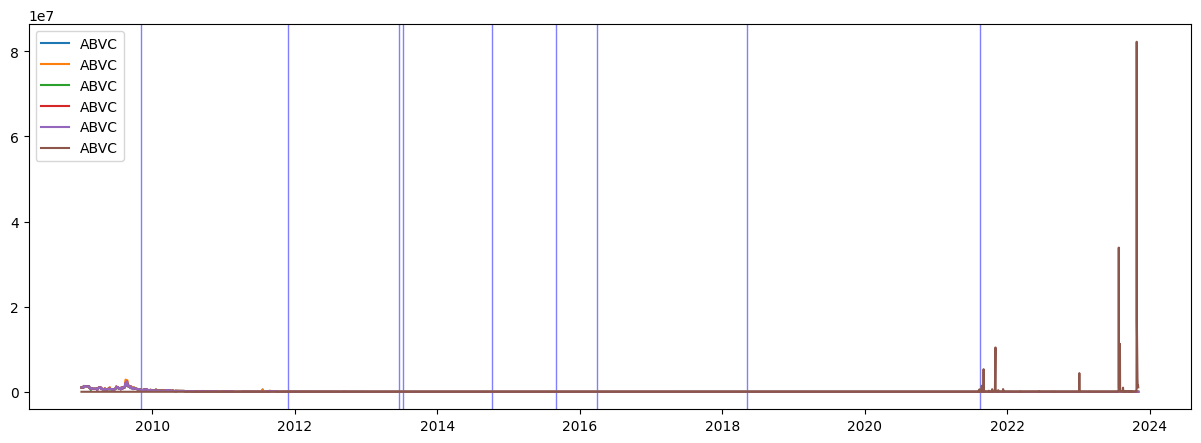

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


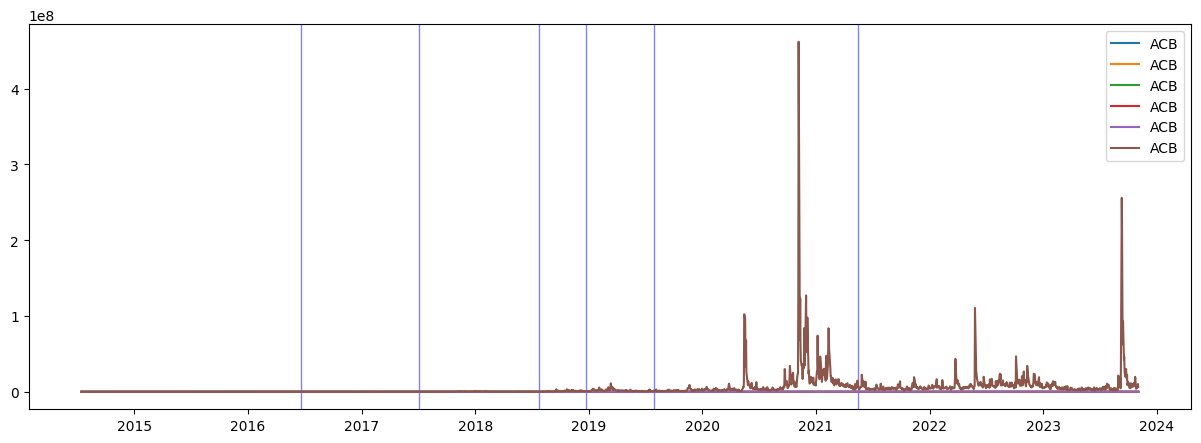

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


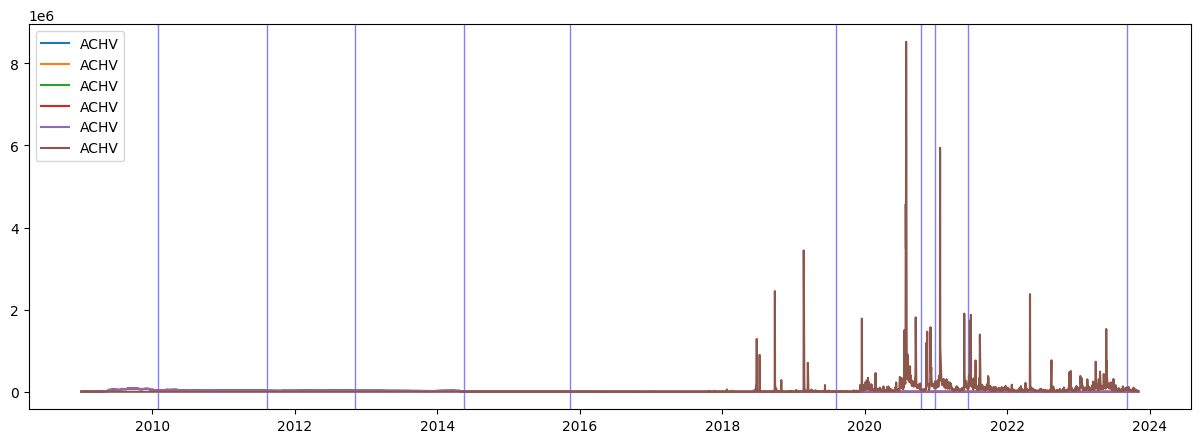

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


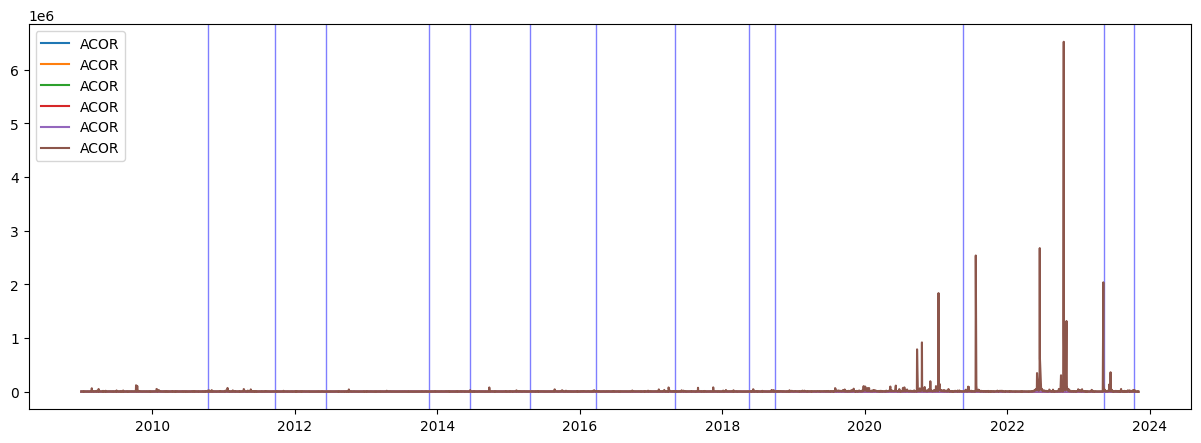

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


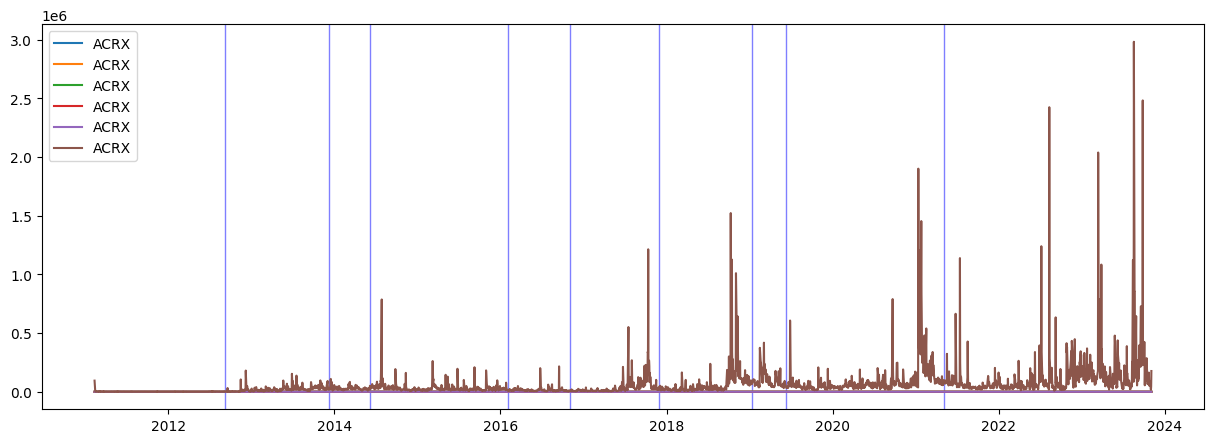

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


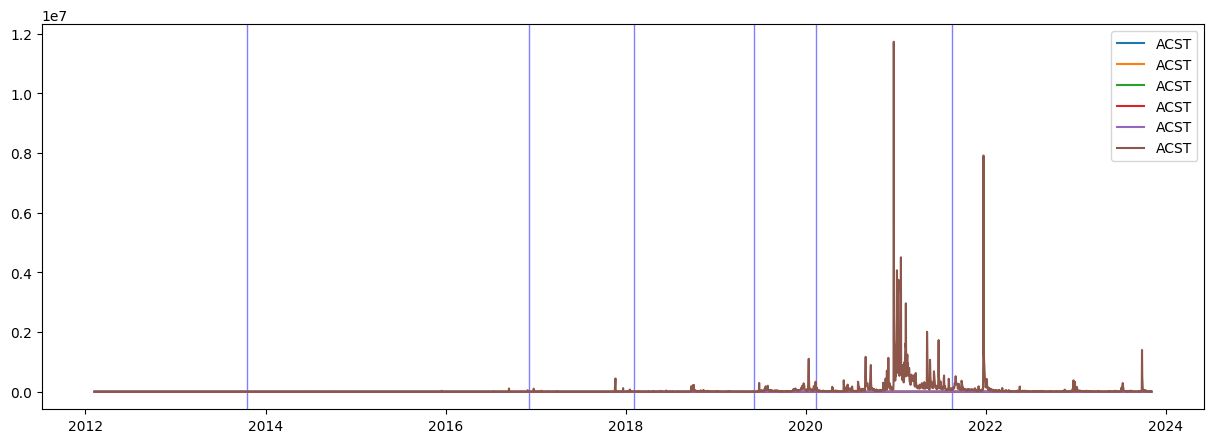

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


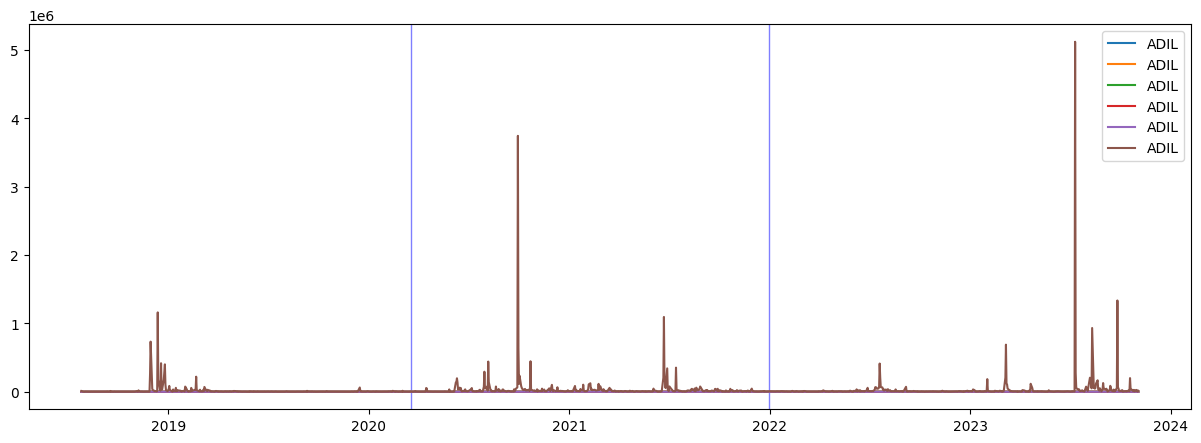

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


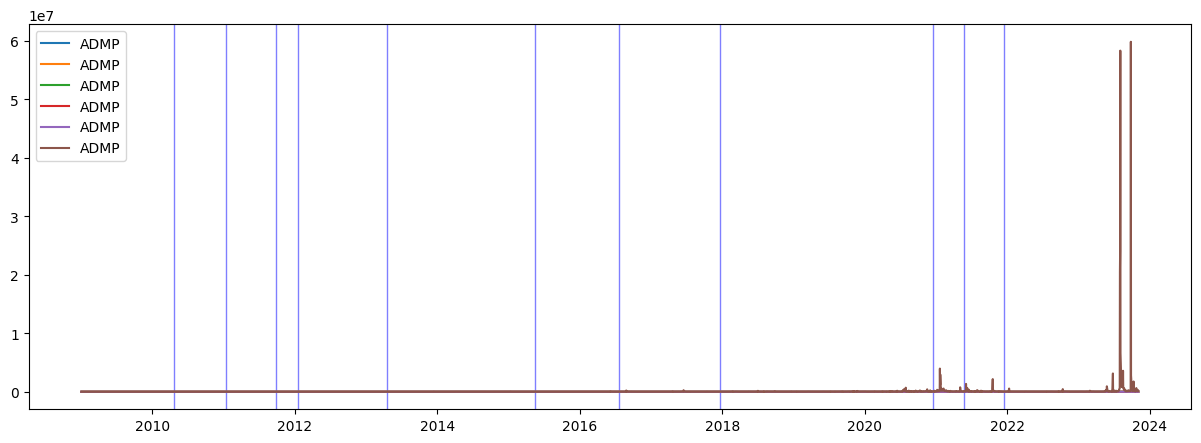

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


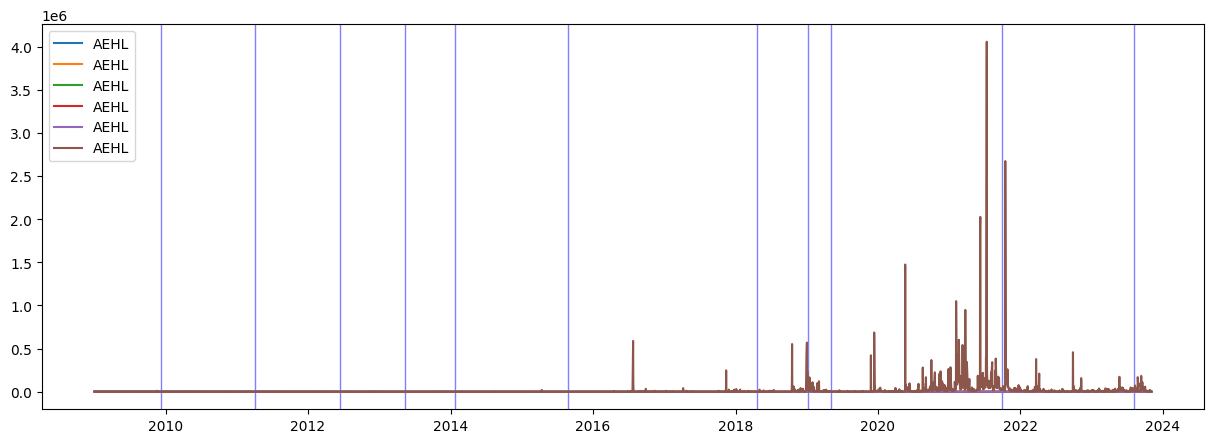

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


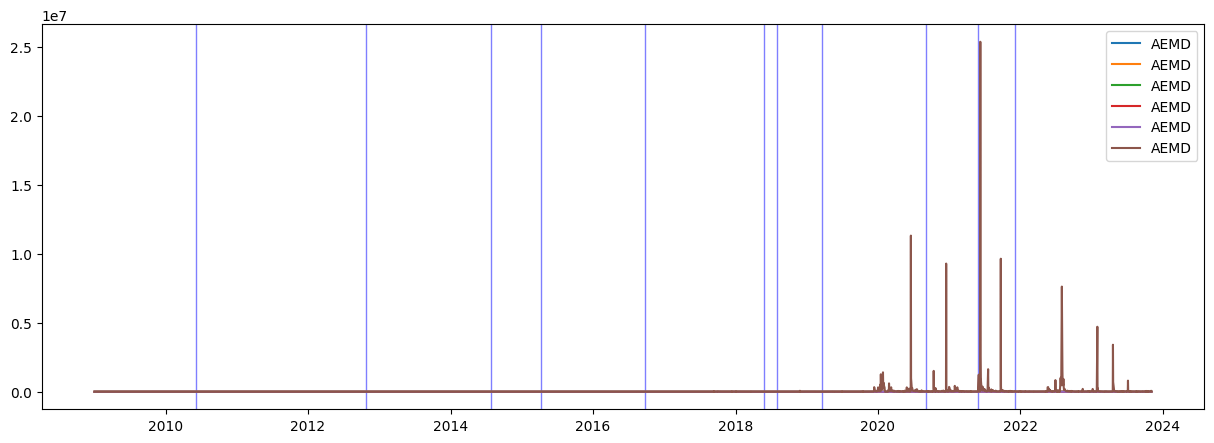

C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\1630094522.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_df['50-day'][i] < temp_df['200-day'][i] and temp_df['50-day'][i - 1] >= temp_df['200-day'][i - 1]:


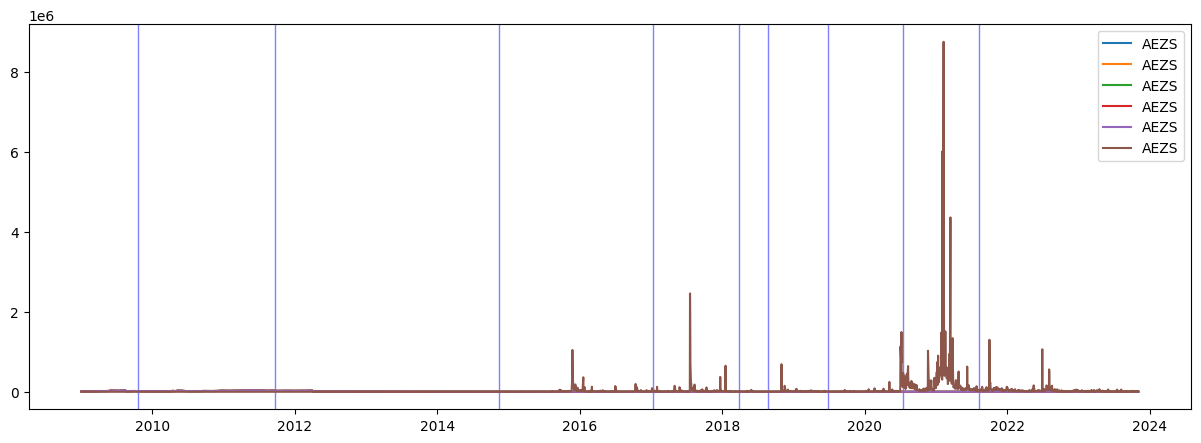

KeyboardInterrupt: 

In [77]:

def run_imps(price_drop_thresh, imp_period, stocks_list):
    num_imp = 0

    j = 0
    for t in stocks_list:
        stock_series = get_stock_price_daily(t)
        if stock_series is not None:
            imp_dates = get_death_crosses(t)
            # if len(imp_dates)!=0:
            #     num_imp+=1
            #     if len(stocks_list)>=450:
            #         plot_implosions(stock_series, imp_dates, t)
            #if j %2 == 0:
            #plot_implosions(stock_series['Adj Close'], imp_dates, t)
            plot_crashes(stock_series, imp_dates, t)
                    
            j+=1
    print(f"Looking at a price drop of {-price_drop_thresh*100}% and an implosion period of {imp_period}, {num_imp} out of {j} imploded!")
    return num_imp

price_drop_threshs = [-0.6]
imp_periods = [252]
imploded_list = imploded_stocks[:50]
sp500_list = sp500_stocks[:5]
max_score = 0
best_price_thresh = best_imp_period = None
for p in price_drop_threshs:
    for i in imp_periods:
        num1 = run_imps(p, i, imploded_list)
        # num2 = run_imps(p, i, sp500_list)
        # if num2 != 0:
        #     if num1/num2 > max_score:
        #         max_score = num1/num2
        #         best_price_thresh = p
        #         best_imp_period = i

In [ ]:
print(max_score, best_imp_period, best_price_thresh)


NameError: name 'max_score' is not defined

175, 52, -0.6
SP500 stocks that have implosions: PYPL, ENPH

Checking the number of imploded stocks that crash

In [9]:
def does_stock_crash(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        #firm_returns = get_firm_specific_returns(stock_series)
        crash_dates = get_crash_dates(stock_series)
        if len(crash_dates) == 0:
            return False
        else:
            return True

num_imp = 0
    
for t in imploded_stocks[:10]:
    if does_stock_crash(t):
        num_imp+=1
        plot_crashes(t)

print(f'{num_imp} out of {len(imploded_stocks)} experienced crashes')

NameError: name 'get_crash_dates' is not defined

At 0.5% level 427/433 imploded stocks experience crashes using (previous) year mean as threshold

Problem with using returns - 0.1% dist - labels crashes that aren't really that strong
Problem using price - multiple dates next to each other - i think this is fine though

Using 80% drop, weekly stock price, previous year price yields 406/433 stocks suffering crashes
Using 80% drop, weekly stock price, previous year price yields 9/505 sp500 stocks suffering crashes
Using 60% drop, weekly stock price, previous year price yields 424/433 impoded stocks suffering crashes

Extra test on test branch


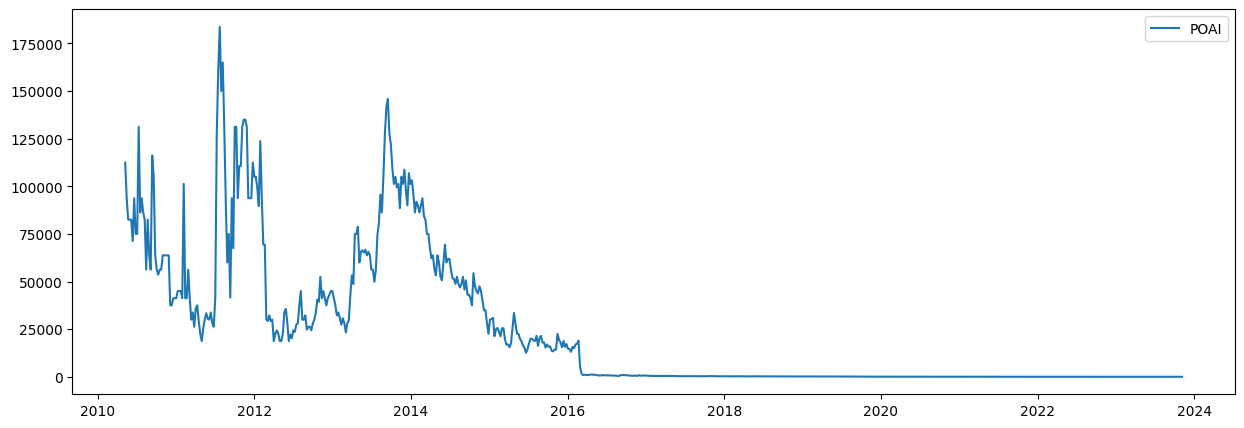

In [ ]:
plot_price(get_stock_price('POAI'), ticker='POAI')

            Adj Close     50-day  200-day
Date                                     
2010-05-09  112500.00        NaN      NaN
2010-05-16   93750.00        NaN      NaN
2010-05-23   82500.00        NaN      NaN
2010-05-30   82500.00        NaN      NaN
2010-06-06   82500.00  90750.000      NaN
...               ...        ...      ...
2023-10-08       3.50      3.362  5.51575
2023-10-15       3.96      3.366  5.43025
2023-10-22       3.34      3.392  5.27225
2023-10-29       2.86      3.372  5.13375
2023-11-05       3.45      3.422  4.99250

[705 rows x 3 columns]


C:\Users\zakit\AppData\Local\Temp\ipykernel_31112\2304345976.py:203: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (temp_df['Adj Close'][i] - temp_df['Adj Close'][start_i])/temp_df['Adj Close'][start_i] < -0.6:


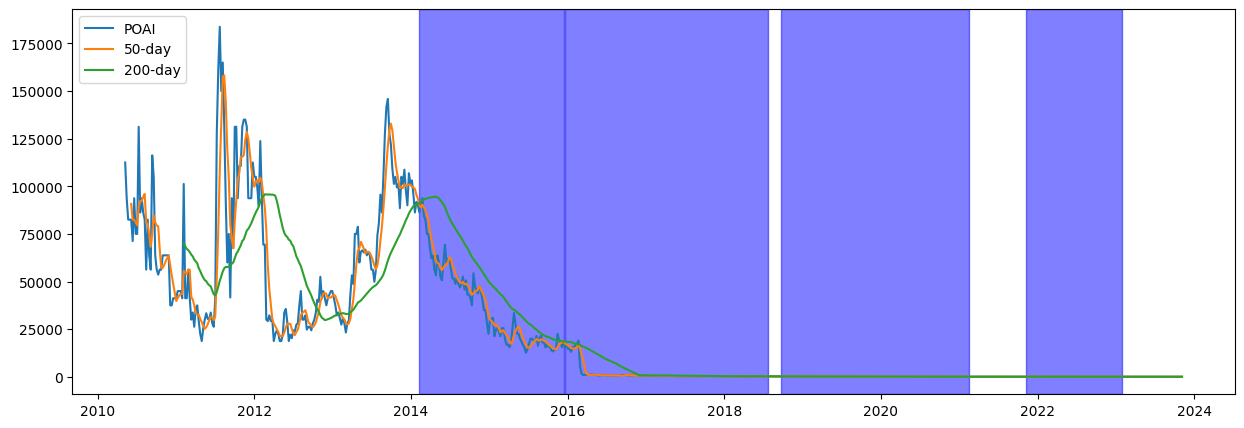

In [56]:
ds = get_stock_price("ATHE").to_frame()
dd_df = []
pmin_pmax = (ds['Adj Close'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
pmax = pmin_pmax[pmin_pmax == 1]
pmin = pmin_pmax[pmin_pmax == -1]
if pmin.index[0] < pmax.index[0]:
    pmin = pmin.drop(pmin.index[0])
if pmin.index[-1] < pmax.index[-1]:
    pmax = pmax.drop(pmax.index[-1])

dd = (np.array(ds['Adj Close'][pmin.index]) - np.array(ds['Adj Close'][pmax.index])) \
    / np.array(ds['Adj Close'][pmax.index])

dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
        'duration': dur}  
  
df_d = pd.DataFrame(d).set_index('Date')
df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
df_d = df_d.sort_values(by='drawdown')
df_d['rank'] = list(range(1,df_d.shape[0]+1))

major_dds = df_d[df_d['drawdown'] < -0.6].index.tolist()

# plot_crashes('ATHE',  major_dds)
# do_implosion('ABEO')
# plot_cum_ret(get_stock_price("ABEO"), "ABEO")
plot_mas('POAI')


Alternative definition - look for point where 50-day moving average moves below 200-day moving average - check 12 months later for 80% drop - check 12 months no 40% rise

In [ ]:
df_d

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2014-03-23,-0.828545,2014-03-23,2014-04-13,15,1
2016-09-11,-0.548450,2016-09-11,2016-11-06,40,2
2009-02-08,-0.519651,2009-02-08,2009-03-08,20,3
2016-11-20,-0.400735,2016-11-20,2017-01-01,30,4
2020-03-08,-0.400000,2020-03-08,2020-03-22,10,5
...,...,...,...,...,...
2012-03-25,-0.011696,2012-03-25,2012-04-01,5,200
2019-08-18,-0.009091,2019-08-18,2019-08-25,5,201
2015-03-15,-0.008621,2015-03-15,2015-03-22,5,202


## Implosion Detection

## Testing detection on Imploded Stocks vs S&P500 stocks